In [2]:
import os 
os.chdir("..")

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from utils.visualization import plot_molecules, plot_molecule
from utils.preprocessing import get_average_trajectory_positions, get_time_distance_matrix
import processor.data as data_processor
import processor.graph as graph_processor
import utils.metrics as metrics
from utils.export import *

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU not available. Using CPU.


# Load data

In [37]:
integrin = "aVb3"    # "a5b1"
data_type = "clamp"  # Ramp 
u, extensions, config = data_processor.load_data(data_type, integrin)

In [38]:
# visualize 
t = 0
rep = 0

# set to first frame 
u[rep][extensions[t]].trajectory[0] 

plot_molecules(
    [
        u[rep][extensions[t]].select_atoms(f"protein and name CA").positions
    ]
)

# Define domains

In [33]:
# define domains 
ext = extensions[0]

if integrin == "aVb3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "alphaVbeta3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-956").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 957-984").atoms.resindices,
        # "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        # "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-692").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 693-725").atoms.resindices,
        # "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        # "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "a5b1":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-449").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 450-602").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 603-611").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 612-748").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 749-947").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 121-360").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 65-120 or resid 361-441)").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-64").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 442-444").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 445-480").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 481-533").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 534-570").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 571-610").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 611-703").atoms.resindices
    }
    
elif integrin == "alpha2bbeta3":
    # https://www.cell.com/molecular-cell/fulltext/S1097-2765(08)00839-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1097276508008393%3Fshowall%3Dtrue 
    # Zhu, Jianghai, et al. "Structure of a complete integrin ectodomain in a physiologic resting state and activation and deactivation by applied forces." Molecular cell 32.6 (2008): 849-861.
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-451").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 452-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-743").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 744-965").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 966-1080").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 989-1080").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1008-1063").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 1064-1115 or resid 1360-1440)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1116-1359").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1444-1479").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1480-1529").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1530-1566").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1567-1607").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1608-1699").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1700-1732").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1733-1770").atoms.resindices,
    }
else:
    domain_to_residues = {
        "molecule": u[0][ext].select_atoms(f"protein and name CA").atoms.resindices,
    }
    
residue_to_domain = {}
for domain, residues in domain_to_residues.items():
    for residue in residues:
        residue_to_domain[residue] = domain

domain_to_chain = {
    'beta-propeller': "A", 
    'thigh': "A", 
    'loopA': "A", 
    'calf1': "A", 
    'calf2': "A", 
    'transmembrane-alpha': "A", 
    'cytoplasmic-alpha': "A", 
    'psi': "B", 
    'hybrid': "B",
    'betaI': "B", 
    'loopB': "B", 
    'egf1': "B", 
    'egf2': "B", 
    'egf3': "B", 
    'egf4': "B", 
    'betaTD': "B", 
    'transmembrane-beta': "B", 
    'cytoplasmic-beta': "B"
}


# Construct graph

In [34]:
# construct molecular graph sequence 
graph_sequences, dygraph_sequences, resindices_to_index, dist_matrices = graph_processor.contruct_graph_dygraph(
    u=u,
    extensions=extensions,
    config=config,
    residue_to_domain=residue_to_domain,
    warm_up_frames=1,
    node_attributes="coords",
    bound_thd = 5, 
    pval_thd = 1e-5
)

ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1620.64it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1774.68it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1751.31it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1783.19it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8535
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1771.40it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1748.87it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1784.45it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1723.15it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8493
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1751.10it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1759.70it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1727.98it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1291.54it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8445
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1790.46it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1735.29it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1751.38it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1694.28it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8481
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1748.22it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1769.88it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1749.76it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1721.79it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8482
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1770.94it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1721.82it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1738.92it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1779.08it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8530


# Run model

In [27]:
from models.gcn_dmon import GCNDMoN
import utils.graph_utils as graph_utils
from utils import metrics
import torch.optim as optim
from scipy import sparse
from training.train_dmon import train
from collections import defaultdict
import networkx as nx
model_type = "dmon"

In [28]:
architecture = [32]
collapse_regularization = 0.3 # [0.2, 0.5]
knowledge_regularization = 0.0 # [5, 10, 20]
sparsity_regularization = 0.0 # 0.001
connectivity_regularization = 0.0
dropout_rate = 0.0
n_clusters = 25
learning_rate = 0.005
initialization = "" # "louvain"
clustering_method = "auto" # "auto", "kmeans"
activation = "gumbelsoft"
n_epochs = 3000
min_nodes = 5

rep = 0
graph_list = graph_sequences[rep]
residue_indices = list(resindices_to_index.keys())
communities_list = []

Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
==========Time 0 ==========
Total parameters: 1049, Trainable parameters: 1049
Epoch 0, Spectral Loss: -0.0323, Collapse Loss: 0.0071, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.0252
Epoch 100, Spectral Loss: -0.3547, Collapse Loss: 0.1121, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.2426
Epoch 200, Spectral Loss: -0.4183, Collapse Loss: 0.1075, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3108
Epoch 300, Spectral Loss: -0.4327, Collapse Loss: 0.1066, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3261
Epoch 400, Spectral Loss: -0.4386, Collapse Loss: 0.1064, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3322
Epoch 500, Spectral Loss: -0.4406, Collapse Loss: 0.1067, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3340
Epoch 600, Spectral Loss: -0.4430, Collapse Loss: 0.1077, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Tot

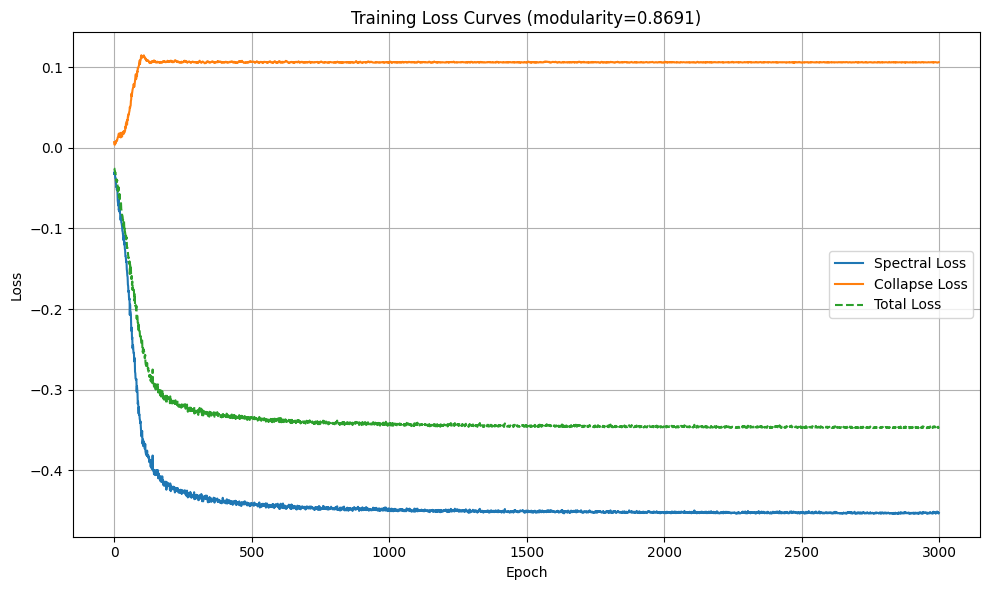

Total trainable parameters: 1049
Total trainable parameters after frozen feature extractor: 1049
Total of  1595 nodes assigned to 14 communities
==========Time 1 ==========
reset model parameters...
Epoch 0, Spectral Loss: -0.4246, Collapse Loss: 0.1144, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3102
Epoch 100, Spectral Loss: -0.4483, Collapse Loss: 0.1064, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3419
Epoch 200, Spectral Loss: -0.4495, Collapse Loss: 0.1061, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3434
Epoch 299, Spectral Loss: -0.4509, Collapse Loss: 0.1058, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3451
Modularity: 0.8611, Conductance: 0.0648
clusters (1595,)
[7 7 7 ... 4 4 4]


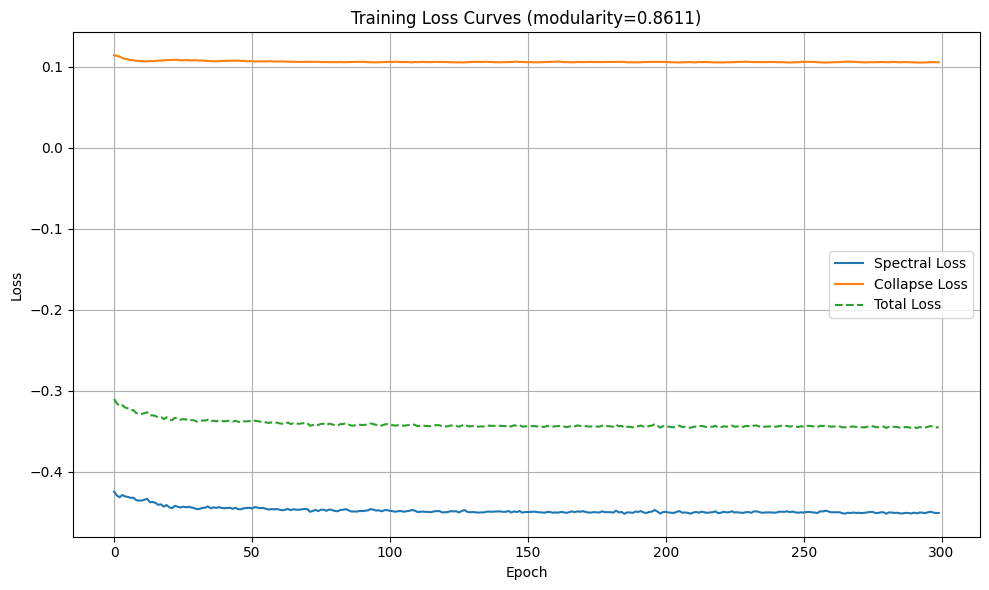

Total of  1595 nodes assigned to 14 communities
==========Time 2 ==========
reset model parameters...
Epoch 0, Spectral Loss: -0.4155, Collapse Loss: 0.1473, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.2682
Epoch 100, Spectral Loss: -0.4355, Collapse Loss: 0.1074, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3281
Epoch 200, Spectral Loss: -0.4363, Collapse Loss: 0.1070, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3292
Epoch 299, Spectral Loss: -0.4358, Collapse Loss: 0.1063, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3296
Modularity: 0.8320, Conductance: 0.0934
clusters (1595,)
[ 7  7  7 ...  4 23 23]


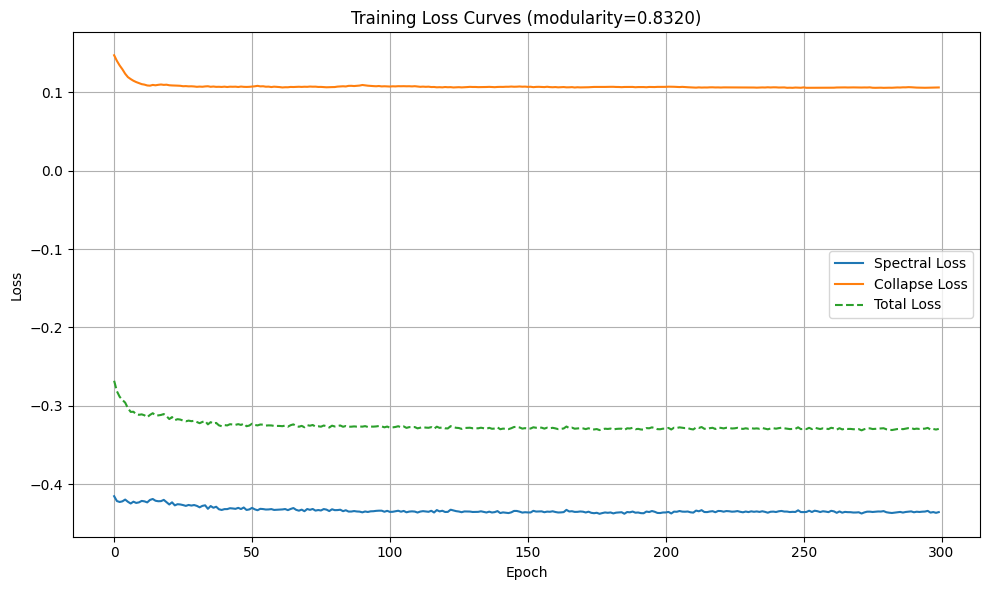

Total of  1595 nodes assigned to 14 communities
==========Time 3 ==========
reset model parameters...
Epoch 0, Spectral Loss: -0.4195, Collapse Loss: 0.1961, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.2235
Epoch 100, Spectral Loss: -0.4279, Collapse Loss: 0.1145, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3134
Epoch 200, Spectral Loss: -0.4287, Collapse Loss: 0.1110, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3177
Epoch 299, Spectral Loss: -0.4336, Collapse Loss: 0.1074, Knowledge Loss: 0.0000, Sparsity Loss: 0.0000, Total Loss: -0.3261
Modularity: 0.8244, Conductance: 0.1022
clusters (1595,)
[ 7  7 10 ...  4 23 23]


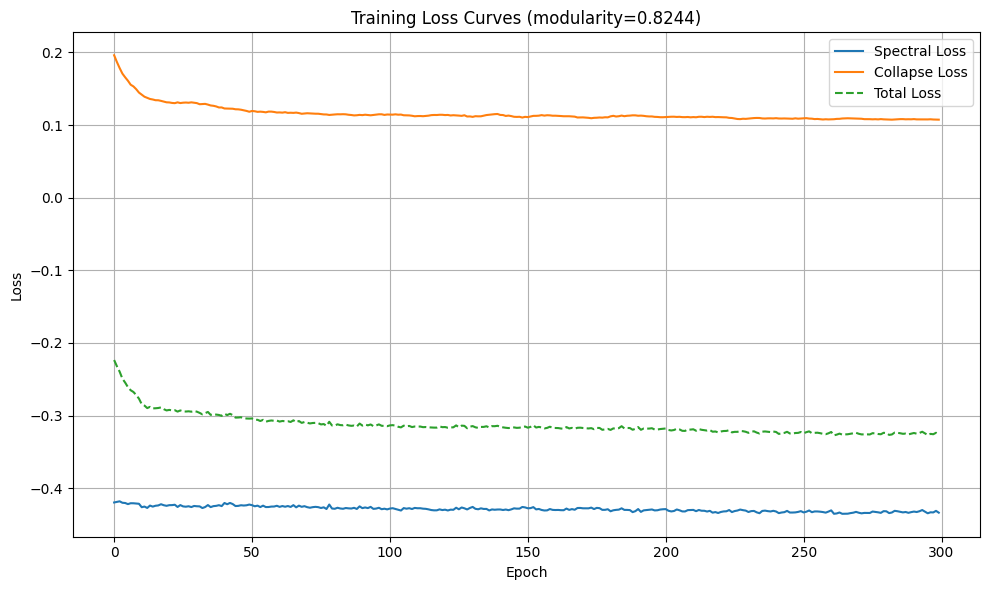

Total of  1595 nodes assigned to 14 communities


In [24]:
communities = defaultdict(dict)
for t in range(len(extensions)):
    
    # Load and process the data
    adjacency = sparse.csr_matrix(nx.to_scipy_sparse_array(graph_list[t], format='csr'))
    features = torch.FloatTensor(np.array([graph_list[t].nodes[n]['feature'] for n in sorted(graph_list[t].nodes)]))
    if t == 0: print(f"Data shape: {features.shape}, adjacency shape: {adjacency.shape}")
    
    print("==========Time", t, "==========")
    
    # run model 
    if t == 0:
        if initialization == "louvain":
            clusters, model, modularity, assignments = train(adjacency, features, n_epochs = 0, plot=True, 
                                                    architecture=architecture, collapse_regularization=collapse_regularization, 
                                                    knowledge_regularization=knowledge_regularization, connectivity_regularization=connectivity_regularization, 
                                                    sparsity_regularization=sparsity_regularization, 
                                                    dropout_rate=dropout_rate, n_clusters=n_clusters, learning_rate=learning_rate, initialization=initialization, clustering_method=clustering_method, activation=activation, verbose=True, device=device)
        else:
            clusters, model, modularity, assignments = train(adjacency, features, n_epochs = n_epochs, plot=True, 
                                                    architecture=architecture, collapse_regularization=collapse_regularization, 
                                                    knowledge_regularization=knowledge_regularization, connectivity_regularization=connectivity_regularization, 
                                                    sparsity_regularization=sparsity_regularization, 
                                                    dropout_rate=dropout_rate, n_clusters=n_clusters, learning_rate=learning_rate, initialization="", clustering_method=clustering_method, activation=activation, verbose=True, device=device)
        
        # freeze feature extractor
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {total_params}")
        # for param in model.gcn_layers.parameters():
        #     param.requires_grad = False
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters after frozen feature extractor: {total_params}")
    else:
        clusters, model2, modularity, assignments = train(adjacency, features, assignments,  model=model, n_epochs = n_epochs // 10, plot=True, # model,
                                                architecture=architecture, collapse_regularization=collapse_regularization, 
                                                knowledge_regularization=knowledge_regularization, connectivity_regularization=connectivity_regularization, 
                                                sparsity_regularization=sparsity_regularization, 
                                                dropout_rate=dropout_rate, n_clusters=n_clusters, learning_rate=learning_rate, initialization="", clustering_method=clustering_method, activation=activation, verbose=True)
    
    
    # exclude communities with too few nodes 
    unique, counts = np.unique(clusters, return_counts=True)
    communities_included = list(unique[counts >= min_nodes])
    mask = np.isin(clusters, communities_included)
    filtered_clusters = clusters[mask]
    filtered_nodes = np.nonzero(mask)[0]  # indices of kept nodes
    communities_included = [str(c) for c in communities_included]
    print("Total of ", filtered_nodes.shape[0], "nodes assigned to", len(communities_included), "communities")

    # store data 
    for i in range(len(clusters)):
        node = residue_indices[i]
        cluster = str(clusters[i])
        if cluster in communities_included:
            if node in communities[str(cluster)]:
                communities[str(cluster)][node].append(t)
            else:
                communities[str(cluster)][node] = [t]

In [35]:
# run the above for n_rep times 
communities_list.append(communities)

In [36]:
# Export to json 
communities_list = [convert_keys_to_builtin(c) for c in communities_list]
os.makedirs(f'results/{model_type}/{integrin}_{data_type}', exist_ok=True)
with open(f'results/{model_type}/{integrin}_{data_type}/communities_raw.json', 'w') as f:
    json.dump(communities_list, f, indent=4)